In [1]:
import os
from IPython.display import display # to print out nice tables
import numpy as np
import pandas as pd
from cobaya.yaml import yaml_load_file
from getdist import mcsamples, plots as ps
from getdist.gaussian_mixtures import GaussianND
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 250

Fiducial values of cosmological parameters, and their $\LaTeX$ labels:

In [3]:
fids = {'ombh2': 0.02237,
        'omch2': 0.1200,
        'omegabh2': 0.02237,
        'omegach2': 0.1200,
        'ns': 0.9649,
        'logA': 3.044,
        'As': np.exp(3.044) * 1.e-10,
        'theta': 1.04092/100,
        'theta_MC_100': 1.04092,
        'H0': 67.36,
        'tau': 0.0544,
        'nnu': 3.046,
        'mnu': 0.06,
        'sigma8': 0.8111,
        'HMCode_logT_AGN': 7.8}

param_labels = {'As': r'$A_\mathrm{s}$', 'ns': r'$n_\mathrm{s}$', 'H0': r'$H_0$', 
                  'ombh2': r'$\Omega_\mathrm{b} h^2$', 'omch2': r'$\Omega_c h^2$',
                  'tau': r'$\tau$', 'logA': r'$\ln \left(10^{10} A_\mathrm{s}\right)$', 
                  'theta_MC_100': r'$100\theta_\mathrm{MC}$', 'theta': r'$\theta_\mathrm{MC}$',
                  'nnu': r'$N_\mathrm{eff}$', 'mnu': r'$\sum m_\nu$',
                  'HMCode_logT_AGN': r'$\log_{10}\left(T_\mathrm{AGN}/\mathrm{K}\right)$'}

# Load in your chains with `getdist`

Set the variable `cobaya_yaml_file` below to the name (including the path) of the input Cobaya YAML file that was used to run the MCMC chains.

You can also set a `legend_label` to use for legends in plots.

In [5]:
cobaya_yaml_filename = 'example_cmbhd.yaml'
legend_label = 'CMB-HD Delensed'


info = yaml_load_file(cobaya_yaml_filename)
if os.path.isabs(info['output']):
    chain_path = info['output']
else:
    chain_path = os.path.join(os.path.dirname(cobaya_yaml_filename), info['output'])
samples = mcsamples.loadMCSamples(info['output'], settings={'ignore_rows': 0.3})

# Monitor the progress of your chains

Check the convergence of the chains:

In [6]:
print('R-1 = ', samples.getGelmanRubin())

R-1 =  0.021927903574040383


Plot the acceptance fraction and the R-1 value over time:

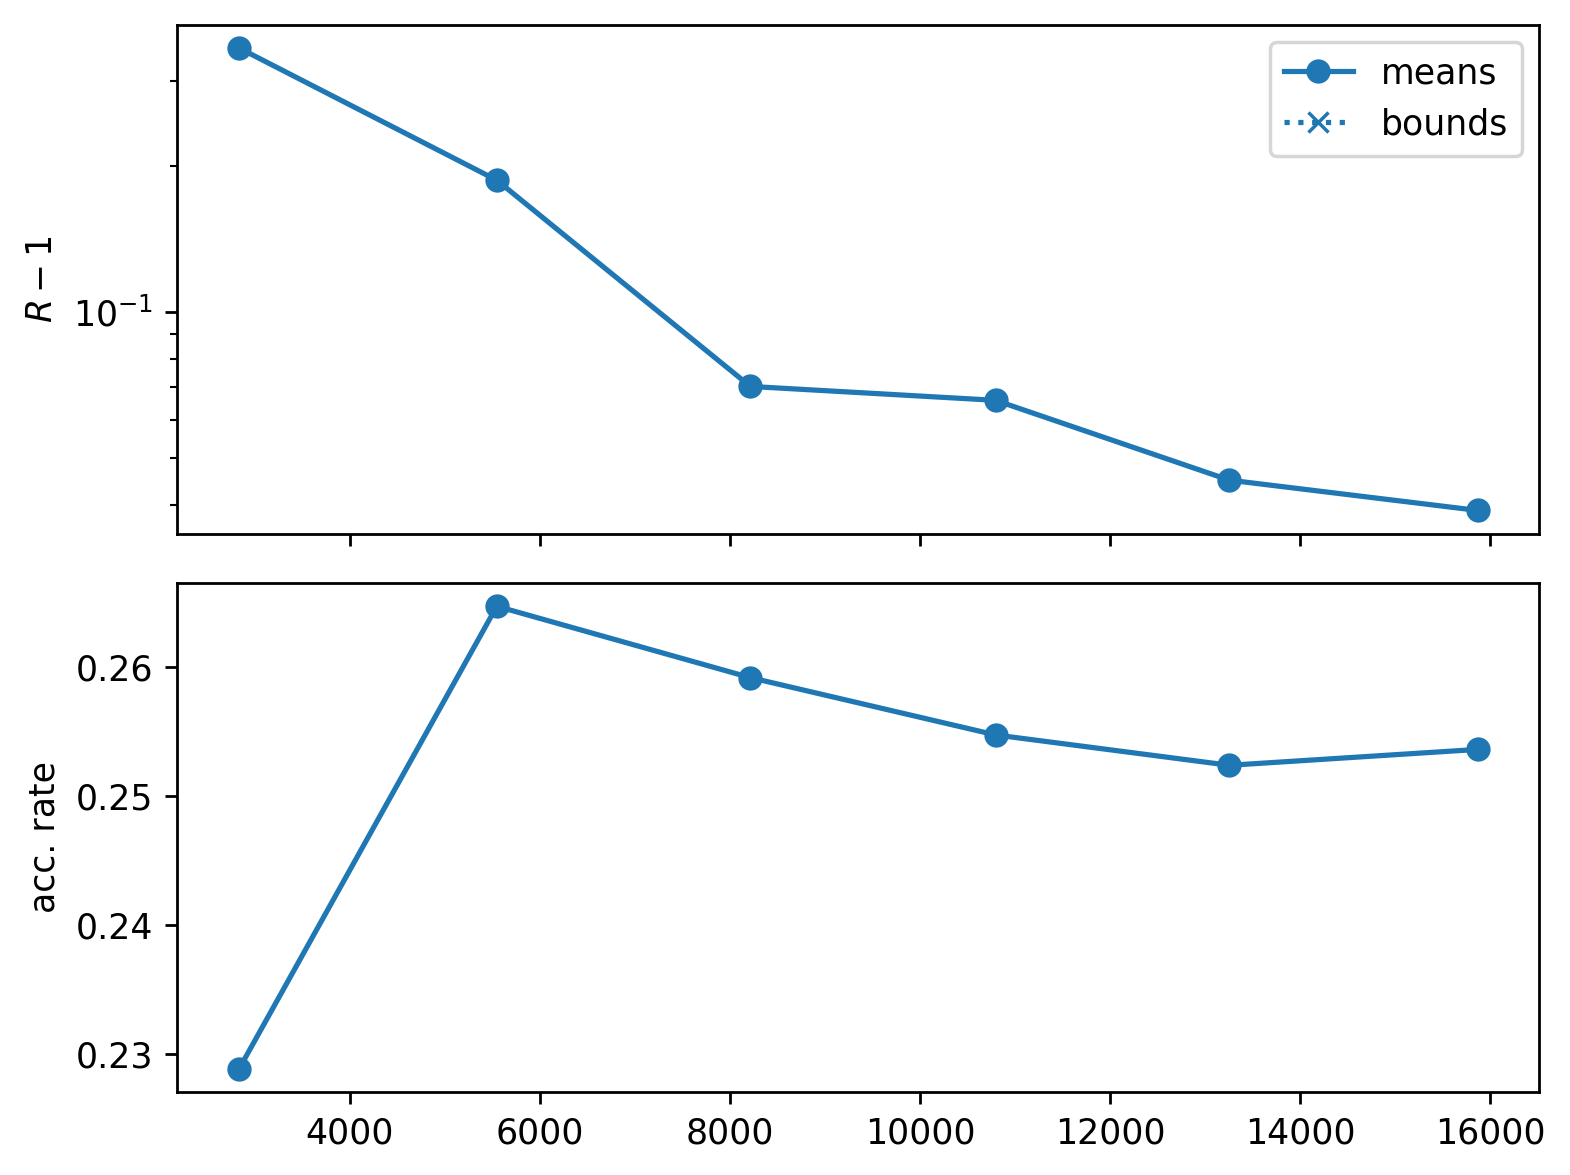

In [7]:
from cobaya.samplers.mcmc import plot_progress
plot_progress(chain_path)
plt.tight_layout()
plt.show()

Make a triangle plot for the parameters, with the $\chi^2$ value indicated by the color of the points:

In [9]:
all_params = info['params'].keys()
sampled_params = []
derived_params = []
for param in all_params:
    if type(info['params'][param]) == dict:
        if 'prior' in info['params'][param].keys():
            sampled_params.append(param)
        else:
            derived_params.append(param)

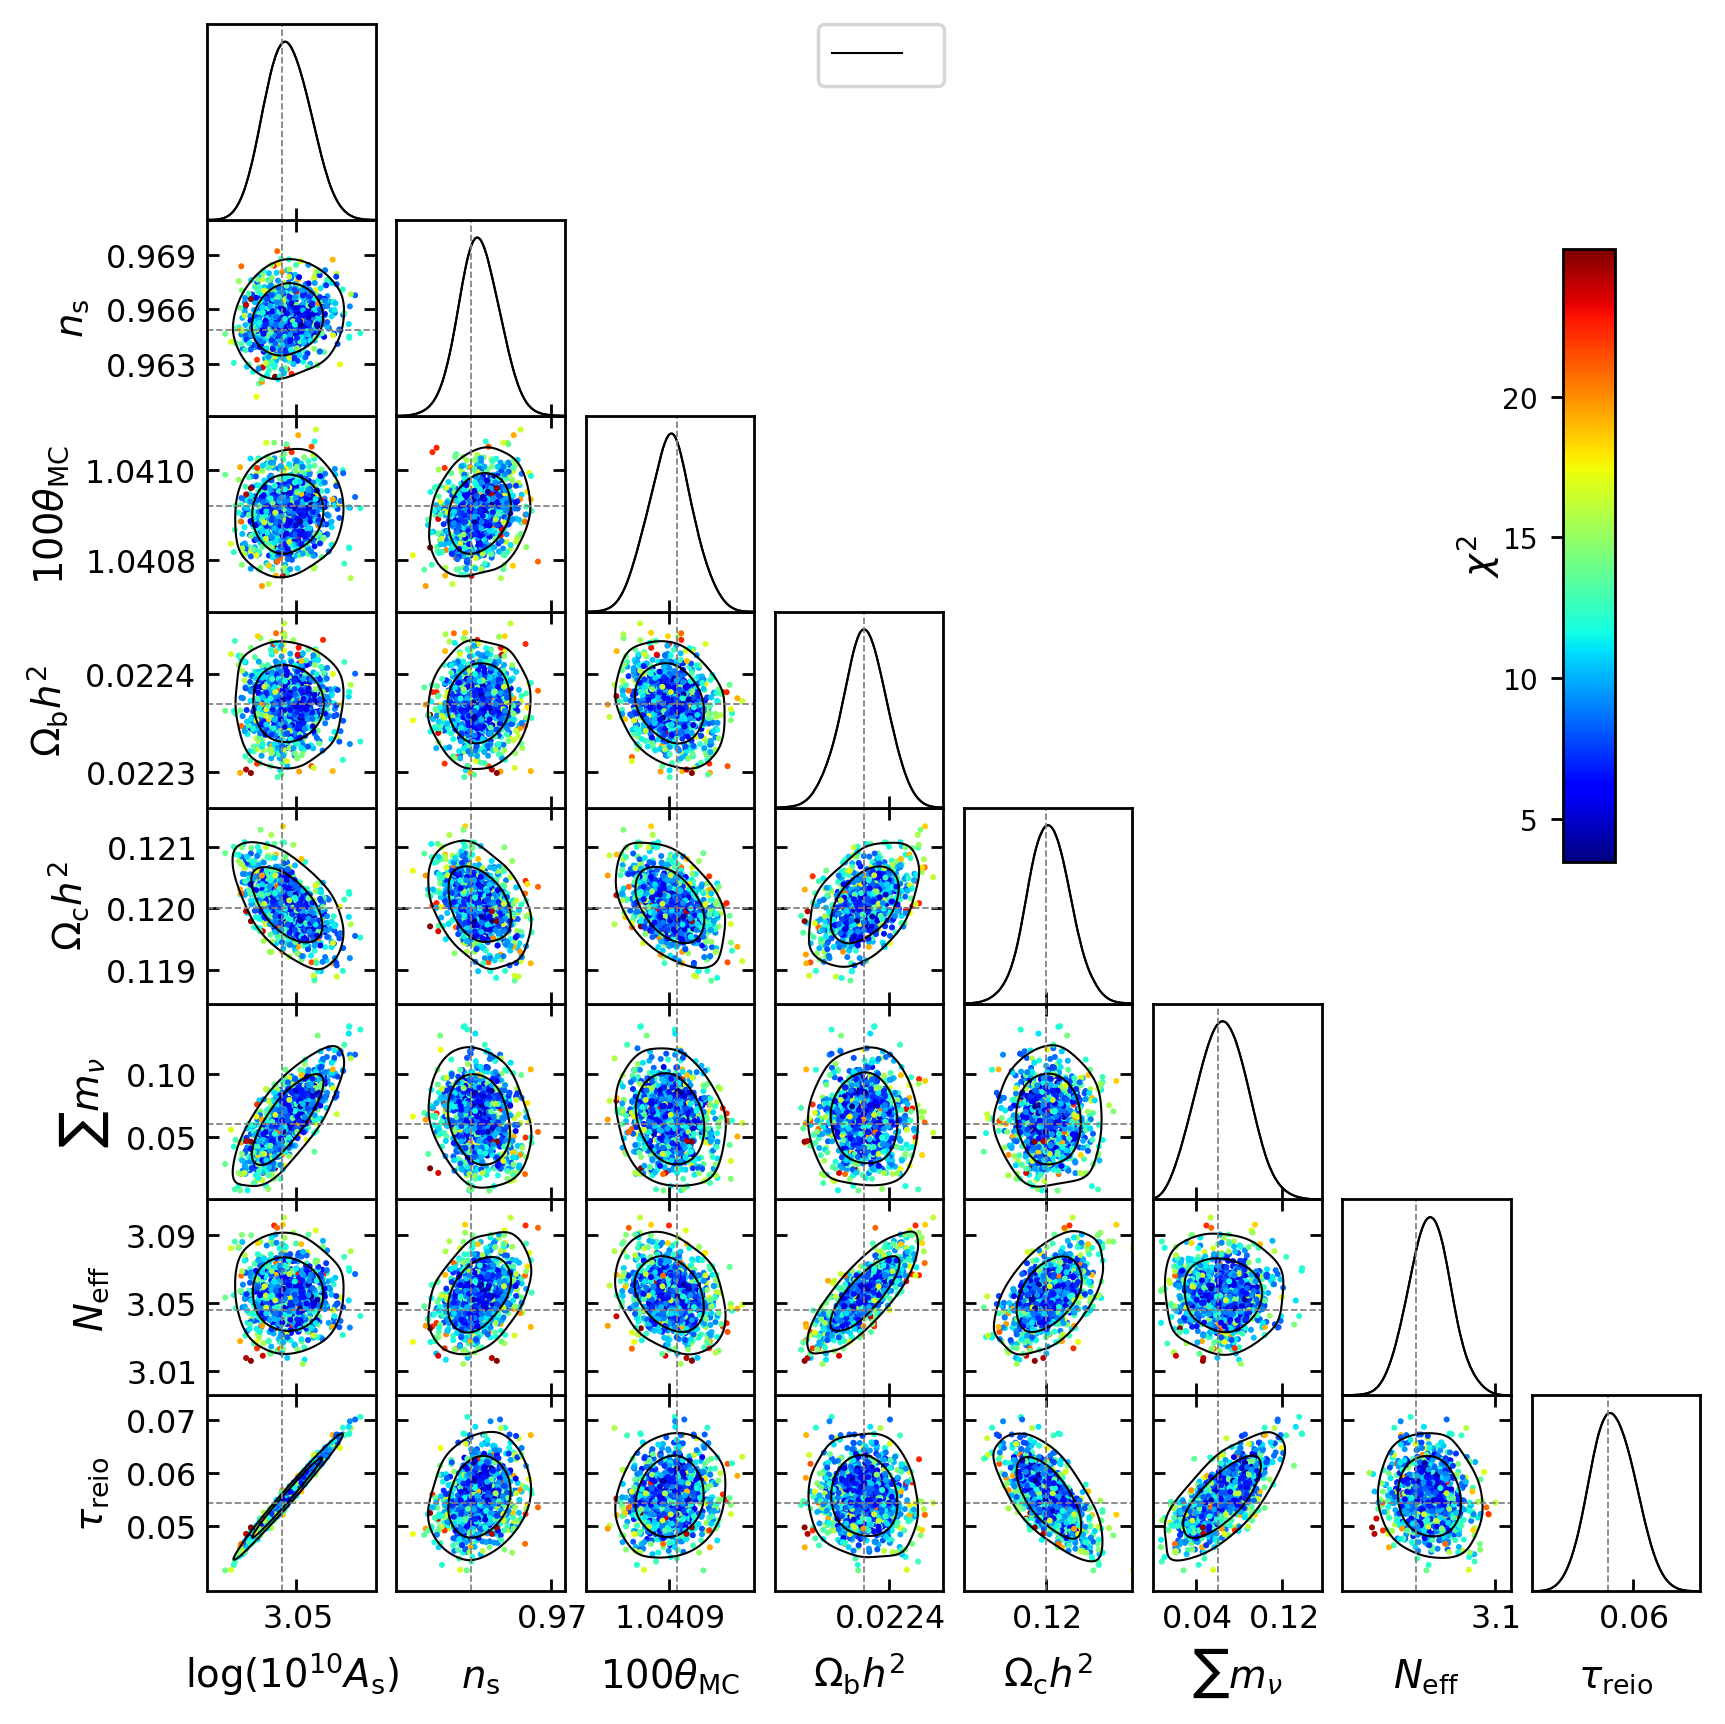

In [10]:
g = ps.get_subplot_plotter(width_inch=7)
g.settings.scaling_factor = 1.1
g.settings.legend_fontsize = 13
g.settings.axes_fontsize = 12
g.triangle_plot([samples, samples], 
                params=sampled_params, filled=False,
                legend_labels=[legend_label],
                contour_colors=['k', 'k'],
                plot_3d_with_param='chi2',
                markers=fids)
plt.show()

### Trace plot

For each parameter, plot the parameter value as a function of the sample number for each chain.

In [11]:
# load in the chain files
if os.path.isdir(chain_path):
    chain_fname = os.path.join(chain_path, '{}.txt')
else:
    chain_fname = chain_path+'.{}.txt'
    
# read in the header of the chain file
with open(chain_fname.format(1), 'r') as f:
    header = f.readline()
header = header.strip('# \n')
columns = header.split()
chain_params = [] # all parameters in the chain, sampled or derived
for col_name in columns[2:]: # first 2 columns are weight and log-posterior
    if ('chi2' not in col_name) and ('minuslogprior' not in col_name):
        chain_params.append(col_name)

# load the chains
n = 1
chains = {col_name: [] for col_name in columns}
while os.path.exists(chain_fname.format(n)):
    chain_data = np.loadtxt(chain_fname.format(n))
    for i, col_name in enumerate(columns):
        chains[col_name].append(chain_data[:,i].copy())   
    n += 1
nchains = n - 1

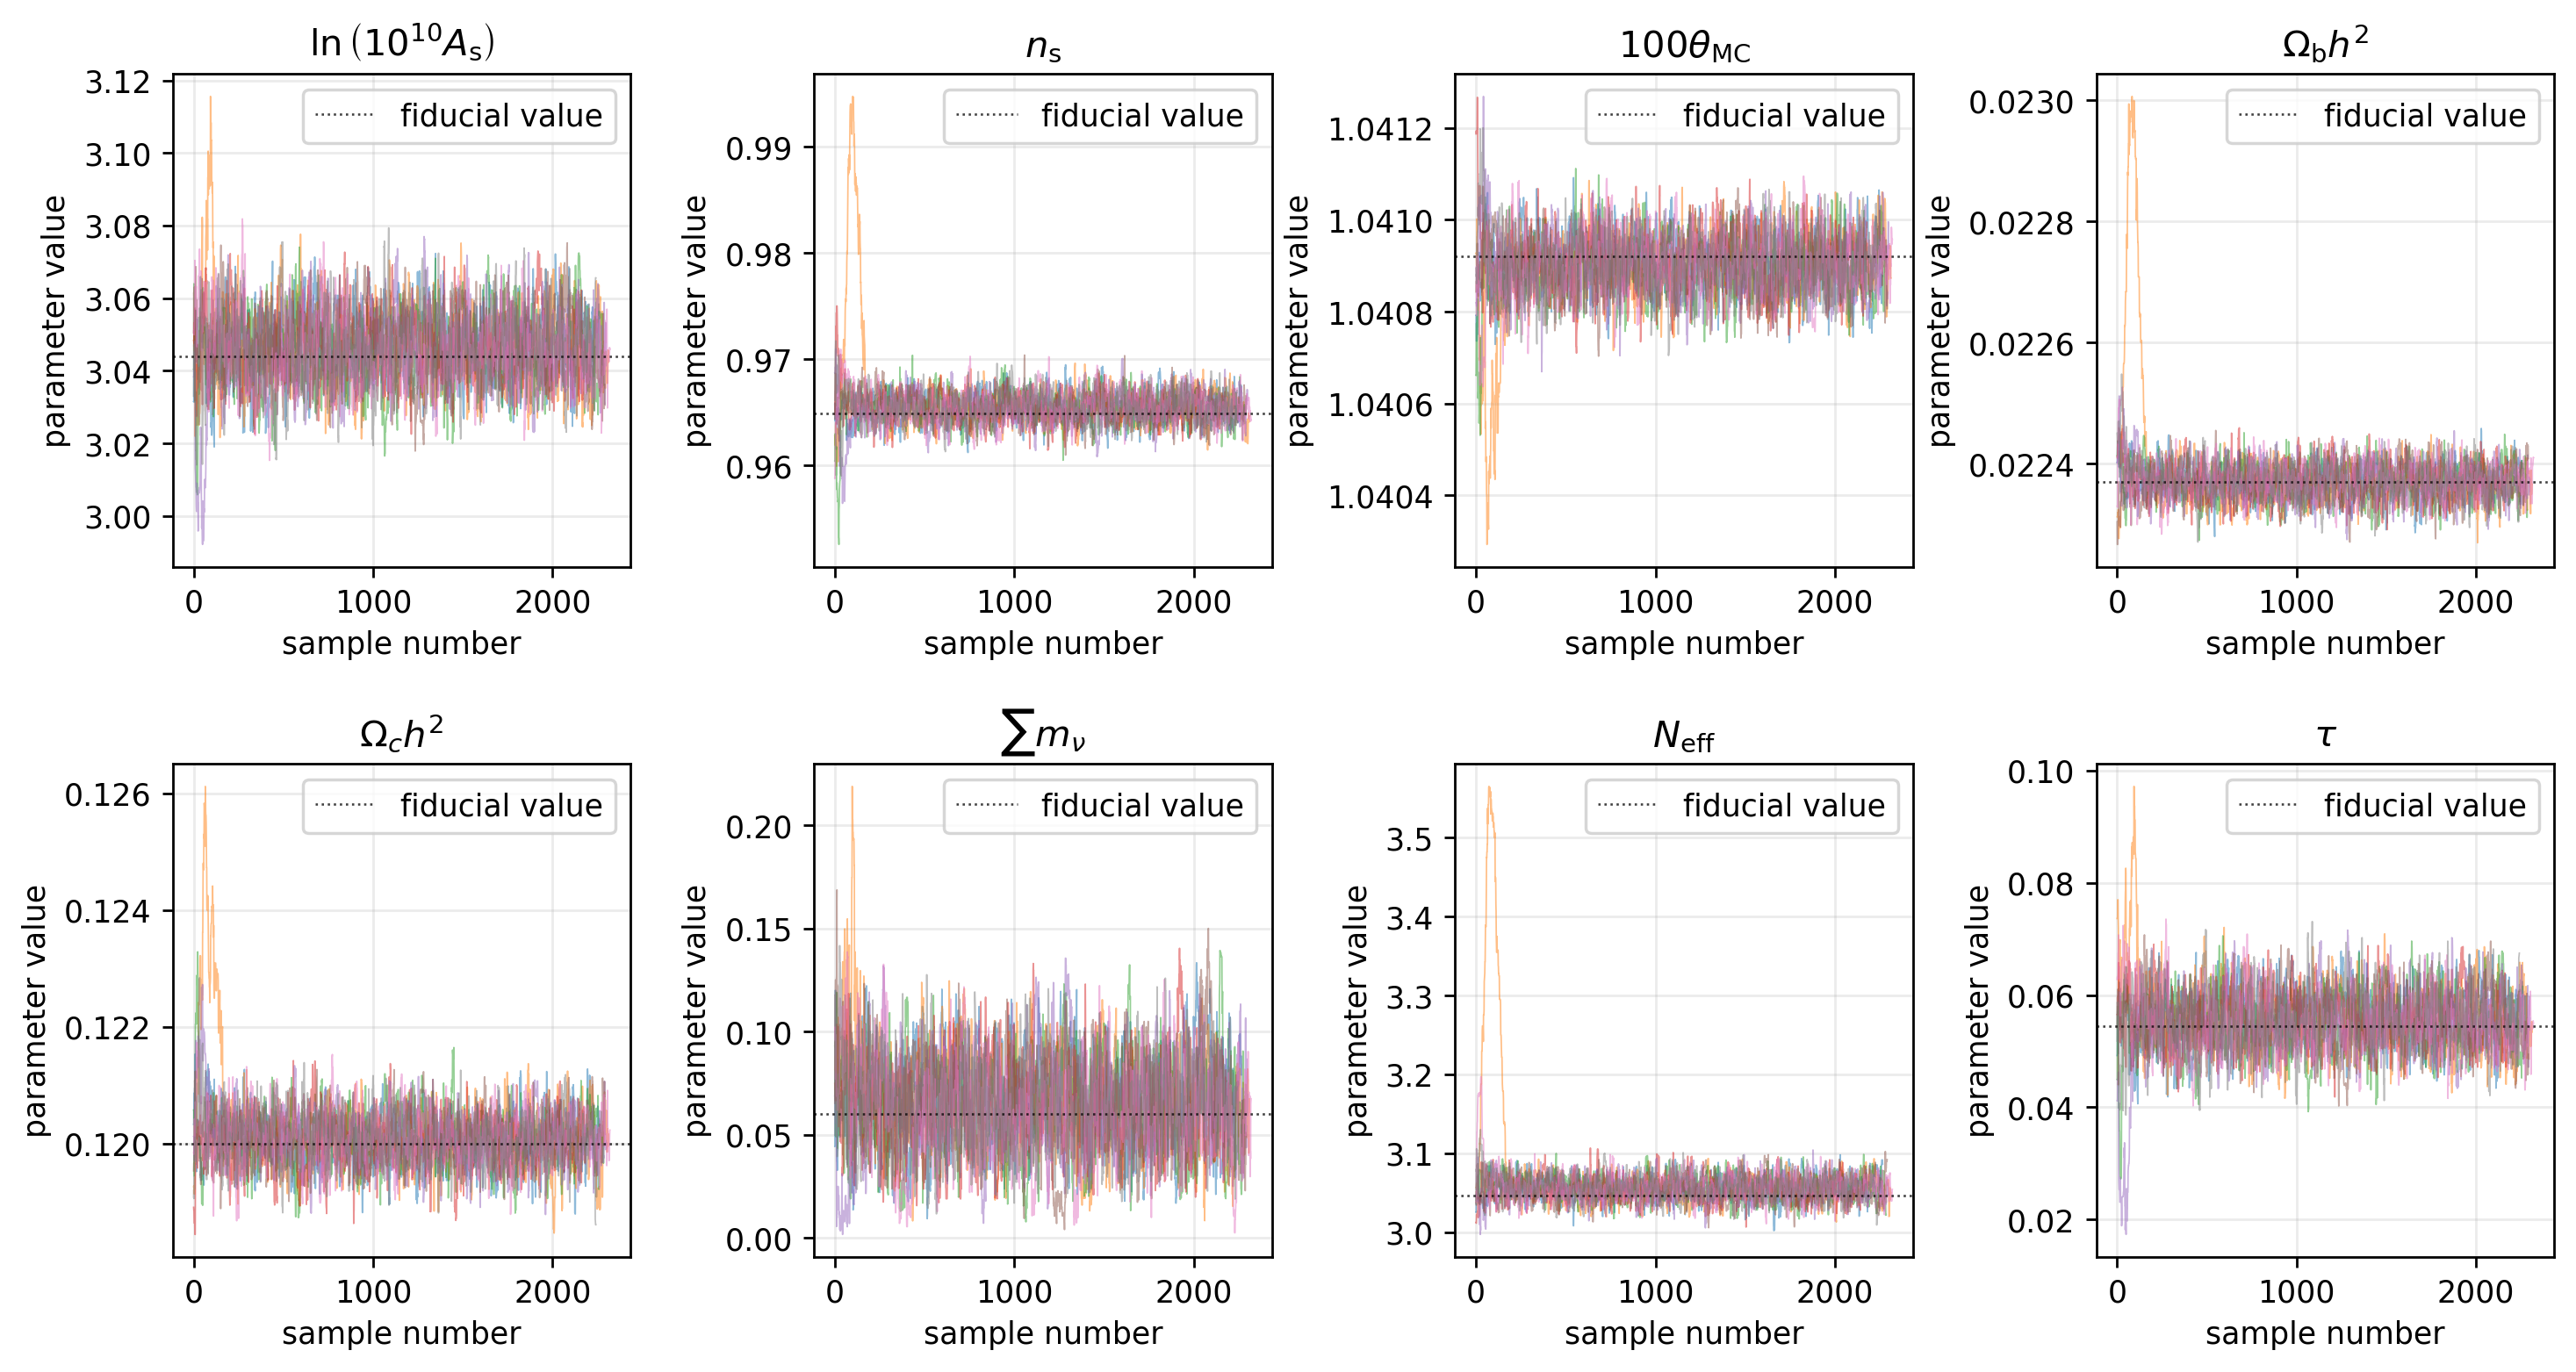

In [12]:
# make the plot
ncol = 4
nrow = int(len(sampled_params)//ncol)
if nrow * ncol < len(sampled_params):
    nrow += 1
    
fig = plt.figure(dpi=250, figsize=(3.5*ncol, 3.5*nrow), facecolor='w')
for i, param in enumerate(sampled_params):
    ax = fig.add_subplot(nrow, ncol, i+1)
    ax.set_title(param_labels[param])
    for i in range(nchains):
        ax.plot(chains[param][i], lw=0.5, alpha=0.5)
    ax.axhline(y=fids[param], color='k', ls=':', lw=0.75, alpha=0.75, label='fiducial value')
    ax.grid(alpha=0.25)
    ax.legend()
    ax.set_xlabel('sample number')
    ax.set_ylabel('parameter value')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

# Get the marginalized means and error bars

Define some useful functions to print the results:

In [13]:
ndigits = {'ombh2': 6, 'omch2': 5, 'logA': 3, 'ns': 4, 'tau': 4, 'H0': 2, 'nnu': 3, 
           'mnu': 3, 'cmin': 2, 'eta0': 3, 'As': 12, 'theta': 7, 'theta_MC_100': 5, 'sigma8': 3}


def print_table(list_of_dicts, list_of_labels, title=None, param_list=None):
    table = pd.DataFrame(list_of_dicts, index=list_of_labels, columns=param_list)
    table = table.T
    title = ' ' if title is None else title
    """
    table.style.set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'k'),
        ('font-size', '26px')
    ]}])
    """
    print('\n', title)
    display(table)
    

def round_dict(d, ndigits=ndigits):
    """Given a dictionary `d` with numerical values, round each value 
    to the number of digits for that key, given by the `ndigits` dict."""
    rounded = {}
    for key, val in d.items():
        rounded[key] = round(val, ndigits[key])
    return rounded


def get_ratio(dict1, dict2, fill_value=None):
    """Returns a dictionary with the ratio of the values in `dict1` to those 
    in `dict2` for each key they share in common. If the keys don't match, you
    can pass a `fill_value` as a placeholder for any keys not in both dictionaries;
    otherwise leave it as `None` to exclude those keys."""
    rdict = {}
    keys1 = list(dict1.keys())
    keys2 = list(dict2.keys())
    all_keys = list(set(keys1 + keys2))
    for key in all_keys:
        if (key in dict1) and (key in dict2):
            rdict[key] = dict1[key] / dict2[key]
        elif fill_value is not None:
            rdict[key] = fill_value
    return rdict


def frac_diff(dict1, dict2, fill_value=None, as_percent=False):
    """Returns a dictionary with the ratio of the values in `dict1` to those 
    in `dict2` for each key they share in common. If the keys don't match, you
    can pass a `fill_value` as a placeholder for any keys not in both dictionaries;
    otherwise leave it as `None` to exclude those keys."""
    fdiff = {}
    keys1 = list(dict1.keys())
    keys2 = list(dict2.keys())
    all_keys = list(set(keys1 + keys2))
    for key in all_keys:
        if (key in dict1) and (key in dict2):
            fdiff[key] = (dict1[key] - dict2[key]) / dict2[key]
            if as_percent:
                fdiff[key] *= 100
        elif fill_value is not None:
            fdiff[key] = fill_value
    return fdiff

Print a table with columns:
1. parameter name (un-named in the table)
2. marginalized mean: `marginalized mean`
3. marginalized error: `marginalized error`
4. fiducial value: `fiducial`
5. fractional difference of mean vs. fiducial: `(mean - fiducial) / fiducial`
6. difference between mean and fiducial, as a fraction of the error bar: `(mean - fiducial) / error`

If `print_all = True`, print all of the parameters in the chain file (sampled + derived); otherwise only print the parameters in the list contained in `params[root]` for each `root` in `roots`.

In [14]:
means = {}
errors = {}
mstats = samples.getMargeStats()
for param in chain_params:
    par = mstats.parWithName(param)
    means[param] = par.mean
    errors[param] = par.err

In [15]:
print_all = True


if print_all:
    param_names = list(means.keys())
else:
    param_names = sampled_params


marginalized_means = {param: means[param] for param in param_names}
marginalized_errors = {param: errors[param] for param in param_names}
fiducials = {param: fids[param] for param in param_names}
# (mean - fiducial) / fiducial
fdiff = frac_diff(marginalized_means, fiducials)
# (mean - fiducial) / error
diff = {param: means[param] - fids[param] for param in param_names}
diff_vs_error = get_ratio(diff, marginalized_errors)
# print out the table
columns = [marginalized_means, marginalized_errors, fiducials, fdiff, diff_vs_error]
column_names = ['marginalized mean', 'marginalized error', 'fiducial', 
                '(mean - fiducial) / fiducial', '(mean - fiducial) / error']
print_table(columns, column_names)

,marginalized mean,marginalized error,fiducial,(mean - fiducial) / fiducial,(mean - fiducial) / error
logA,3.046354e+00,9.330345e-03,3.044000e+00,0.000773,0.252286
ns,9.654412e-01,1.315162e-03,9.649000e-01,0.000561,0.411505
theta_MC_100,1.040903e+00,5.832804e-05,1.040920e+00,-0.000016,-0.284262
ombh2,2.236986e-02,2.680382e-05,2.237000e-02,-0.000006,-0.005061
omch2,1.200589e-01,4.119547e-04,1.200000e-01,0.000491,0.143010
mnu,6.469845e-02,2.322983e-02,6.000000e-02,0.078308,0.202259
nnu,3.055312e+00,1.454309e-02,3.046000e+00,0.003057,0.640273
tau,5.551472e-02,4.955626e-03,5.440000e-02,0.020491,0.224941
As,2.103941e-09,1.964143e-11,2.098903e-09,0.002400,0.256502
H0,6.740263e+01,2.796729e-01,6.736000e+01,0.000633,0.152425


# Make a triangle plot 

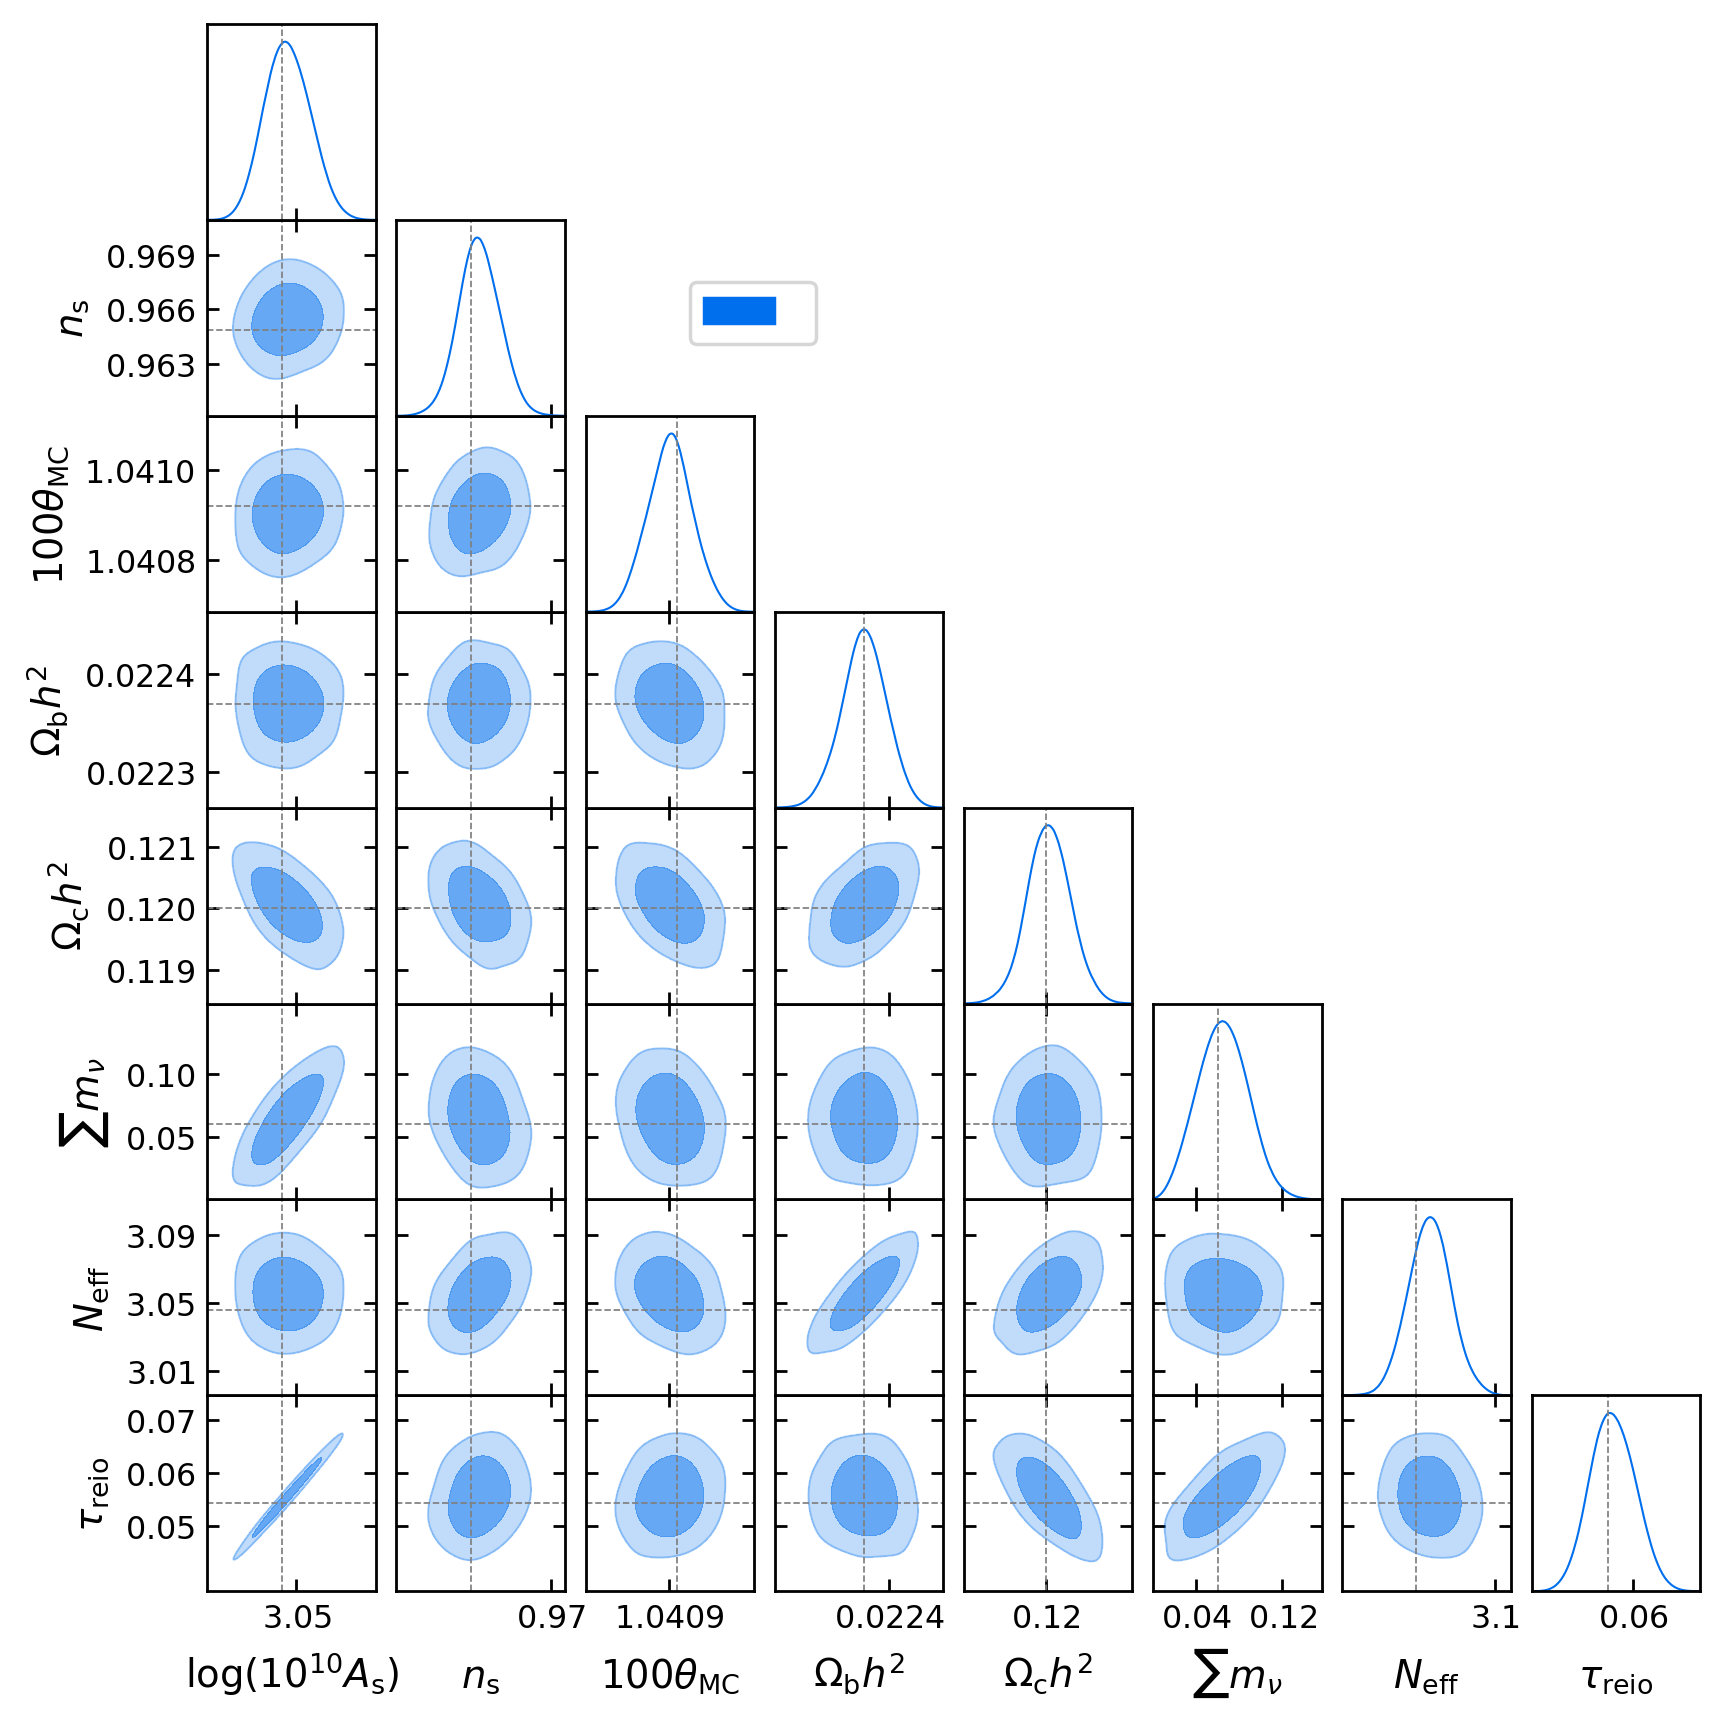

In [16]:
g = ps.get_subplot_plotter(width_inch=7)
g.settings.scaling_factor = 1.1
g.settings.legend_fontsize = 13
g.settings.axes_fontsize = 12
g.triangle_plot([samples], 
                params=sampled_params, filled=True,
                legend_labels=[legend_label],
                #contour_colors=['tab:red', 'tab:blue', 'tab:green', 'tab:orange'],
                alphas=[0.6],
                legend_loc=(0.4, 0.8),
                markers=fids)
plt.show()